In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu
from scipy.stats import norm

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

    Задача
- Запустить A/A-тест
- Посчитать FPR на уровне альфа = 0.05  
- Найти причины поломки сплит-системы, ориентируясь на результаты эксперимента.
- Написать выводы, которые можно сделать на основе анализа результатов A/A-теста

In [3]:
test=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-skurlatova-33/CSVs/hw_aa.csv',sep=';')
test.head()                 

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
test.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

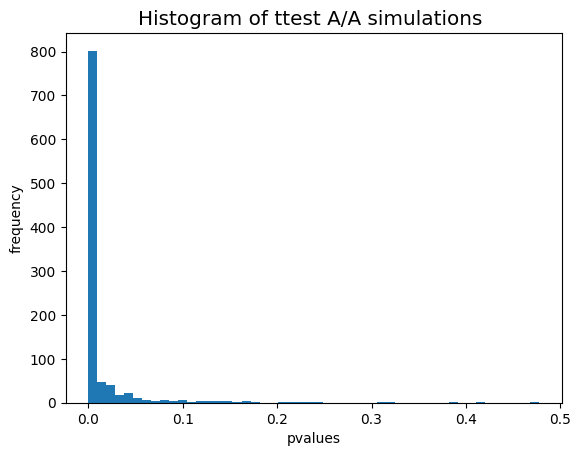

0.93

In [5]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = test[test.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    s2 = test[test.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

False positive rate значительно выше порогового p-value 5%. Для того, чтобы определить, в чем состоит поломка в АА тесте, необходимо провести анализ данных. Проверю, как распределена конверсия в имеющихся вариантах и среди версий приложения

In [6]:
test1=test.groupby(['experimentVariant','version'],as_index=False).agg({'uid':'count','purchase':'mean'})
test1

,experimentVariant,version,uid,purchase
0,0,v2.8.0,41283,0.000993
1,0,v2.9.0,11921,0.074658
2,0,v3.7.4.0,4204,0.059943
3,0,v3.8.0.0,5694,0.057604
4,1,v2.8.0,41552,0.045606
5,1,v2.9.0,12033,0.071304
6,1,v3.7.4.0,4221,0.063018
7,1,v3.8.0.0,6110,0.062848


После группировки данных по вариантам и версиям приложений и подсчета конверсии визуально заметно, что конверсия в версии приложения v.2.8.0 варианта 0 значительно ниже остальных значений. Это и может быть причиной поломки АА теста. Проведу дополнительное исследование.

In [7]:
test1.dtypes

experimentVariant      int64
version               object
uid                    int64
purchase             float64
dtype: object

Для проведения теста на определения различий (или их отсутствия) между вариантами 0 и 1 в разных версиях приложения установлю нулевую гипотезу: между вариантами значимых различий нет. Для проверки этой гипотезы проведу 4 теста Манна-Уитни для установления p-value. За пороговое значение альфа возьму 0.05.
Выбираю данный вид теста, так как он не требует проверки на нормальность распределения среди групп и проверки на гомоскедстичность (в отличии от t-test).

In [8]:
t_028=test.query('experimentVariant==0 & version=="v2.8.0"').purchase
t_128=test.query('experimentVariant==1 & version=="v2.8.0"').purchase

In [9]:
mannwhitneyu(t_028, t_128)

MannwhitneyuResult(statistic=819431781.5, pvalue=0.0)

   Полученное при сравнении двух вариантов приложения версии v.2.8.0 значение p-value показывает, что между вариантами имеются различия, таким образом мы можем отвергнуть нулевую гипотезу и исключить этот версию приложения из АА теста.

In [10]:
t_029=test.query('experimentVariant==0 & version=="v2.9.0"').purchase
t_129=test.query('experimentVariant==1 & version=="v2.9.0"').purchase

In [11]:
mannwhitneyu(t_029, t_129) #p-value>0.05 принимаю нулевую гипотезу

MannwhitneyuResult(statistic=71963272.5, pvalue=0.31829983470708123)

In [12]:
t_0374=test.query('experimentVariant==0 & version=="v3.7.4.0"').purchase
t_1374=test.query('experimentVariant==1 & version=="v3.7.4.0"').purchase

In [13]:
mannwhitneyu(t_0374, t_1374) #p-value>0.05 принимаю нулевую гипотезу

MannwhitneyuResult(statistic=8845256.0, pvalue=0.5568648248217467)

In [14]:
t_0380=test.query('experimentVariant==0 & version=="v3.8.0.0"').purchase
t_1380=test.query('experimentVariant==1 & version=="v3.8.0.0"').purchase

In [15]:
mannwhitneyu(t_0380, t_1380) #p-value>0.05 принимаю нулевую гипотезу

MannwhitneyuResult(statistic=17303962.0, pvalue=0.23185636638957852)

Вариарнты с версией приложения v2.8.0 имеют статзначимые различия. Для проведения АА тесте эта группа не подойдет. Убираем ее из исходного датафрейма

In [16]:
test_aa=test.query('version!="v2.8.0"')
test_aa.version.unique()

array(['v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

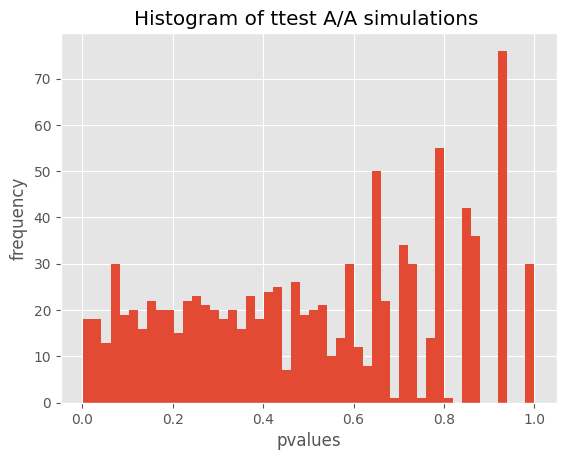

0.044

In [17]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = test_aa[test_aa.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    s2 = test_aa[test_aa.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

После проведения повторного АА теста с датафреймом, из которого были исключены неподходящие значения, получили значение FPR меньше порогового значения в 5%. АА тест сходится.